# Lab Assignment 10

## Group Members
    RAJENDRA KUJUR (214161008)
    ROHIT RAJ SINGH CHAUHAN (21416009)

In [1]:
# importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import torch
from torch import nn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import train_test_split
import cv2

## Question 1

### 1. Application of the Perceptron in Classification of Normal and Shouted Speech using MFCC features. These features are extracted from speech samples of a number of speakers uttering a few sentences normally or by shouting. The features are divided into train-test splits and are made available in two csv files(use the dataset of Assignment 8). You are tasked to learn a discriminative model to classify normal and shouted speech. This example uses Perceptron as a discriminative model. Consider the .csv file “Train_file.csv” containing 86060 instances of 61-dimensional arrays. The first 60 dimensions of the array contain the feature values for a particular instance and the last dimension contains its label. The label can be either ’0’ or ‘1’.

### (a) The perceptron input 𝒙 ∈ ℝ 60 and predicted output 𝑦̂ ∈ (0,1) are related as follows. 𝑢 = 𝝎 𝑇 𝒙 + 𝑏 (𝝎 ∈ ℝ 60 ) 𝑦̂ = (1 + 𝑒 −𝑢 ) −1 Learn the weight vector 𝝎 and bias 𝑏 from the train dataset (Train_file.csv). Do not use any Scikit-Learn functions. Write your own functions for perceptron learning.

In [2]:
df = pd.read_csv('./MFCC/Train_file.csv',header = None)

# separately store labels
labels = df.iloc[:,60]

# leave only features in the df dataframe
df = df.drop(df.columns[[60]], 1)

df.head()

/tmp/ipykernel_26422/2738374283.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(df.columns[[60]], 1)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-10.120651,2.515380,1.823152,1.508992,-1.719560,-1.894340,-1.105240,-1.882580,1.283309,-1.349106,...,0.092580,0.028268,-0.163431,0.032981,0.041419,0.062175,-0.025429,0.072103,-0.054116,0.049799
1,-4.889809,-5.689037,-3.359693,-2.125163,0.261292,-1.499884,0.754239,-1.677804,0.495266,-1.082571,...,0.139837,0.009443,-0.025915,-0.107059,-0.055360,0.010194,-0.097698,-0.105427,-0.088457,-0.021961
2,-1.694022,-5.086290,-4.164934,-2.412973,-4.749922,-0.730738,-0.726216,-2.307999,0.666796,0.516605,...,-0.187182,0.049961,-0.055671,0.001667,-0.203994,0.225937,0.233620,0.110080,0.036043,-0.200711
3,-4.241995,-5.011858,-3.345426,-3.906843,1.229525,1.224371,-0.399490,-1.617319,-0.427983,0.644910,...,-0.029452,-0.059464,0.055713,-0.002794,-0.028805,-0.081924,-0.095755,0.093118,-0.022315,0.148809
4,-3.101878,-6.134078,-3.250782,-3.051343,0.591492,0.893184,-1.925571,-0.913248,0.228131,-0.977734,...,-0.183069,0.128475,-0.208654,-0.075758,0.121429,-0.085190,0.034585,0.233586,0.027971,0.197148


In [3]:
# Data 
X = np.array(df).T

# Labels
Y = np.array(labels).reshape(1,-1)

In [4]:
# initializing the weight and biases to the random values
w = (np.random.randn(df.shape[1])/500).reshape(-1,1)
b = (np.random.randn(1)/500).reshape(-1,1)

In [5]:
# Define activation function as sigmoid
def sigmoid(u):
    fx = (1 + np.exp(-u))**(-1)
    return fx

In [6]:
# weight and bias learning using logistic regression cost function
def propogation(w, b, X, Y):

    m = X.shape[1]
    Y_hat = sigmoid(np.dot(w.T,X) + b)
    cost = (-1/m)*(np.dot(Y,np.log(Y_hat).T) + np.dot((1-Y),np.log(1-Y_hat).T)).reshape(-1)
    dw = (1/m)*(np.dot(X,(Y_hat-Y).T))
    db = (1/m)*np.sum(Y_hat-Y)
    
    gradients = [dw, db]
    
    return gradients, cost

In [7]:
learning_rate = 0.01
costs = []
no_of_batches = 5
# using batch of np.shape(y)[1] / no_of_batches
batch_size = int(np.shape(Y)[1]/no_of_batches)
for i in range(100):
    X_batch = np.array(np.split(X,no_of_batches,1))
    Y_batch = np.array(np.split(Y,no_of_batches,1))
    for j in range(no_of_batches):
        gradients, cost = propogation(w,b,X_batch[j],Y_batch[j])
        costs.append(cost)
        dw = gradients[0]
        db = gradients[1]
        w = w - learning_rate * dw
        b = b - learning_rate * db


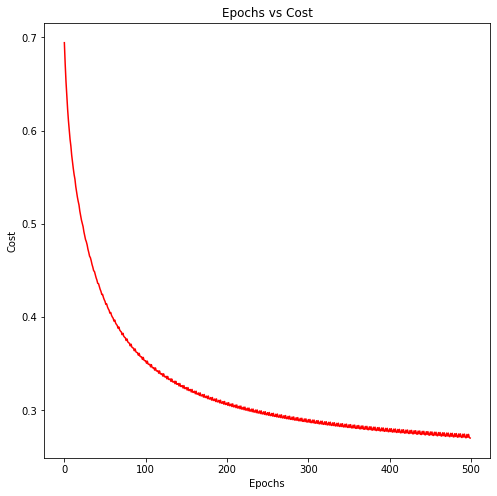

In [8]:
x = np.arange(100*no_of_batches)
plt.figure(figsize=(8,8))
plt.plot(x,costs, color ='red')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Epochs vs Cost')
plt.show()

### (b) Read “Test_file.csv” consisting of 21516 instances of 61 dimensional arrays. For each array, the first 60 dimensions contain the feature values for the test data and the last dimension contains its actual label. Predict the label of each data instance from the testing set using the learned perceptron and compare the predicted and actual labels. Report the class-wise F1-scores for both classes and the overall accuracy.

In [9]:
#read and modify test dataset
df = pd.read_csv('./MFCC/Test_file.csv',header=None)
labels = df.iloc[:,60]
df = df.drop(df.columns[[60]], 1)
df.head()

/tmp/ipykernel_26422/2084707555.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(df.columns[[60]], 1)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,3.863817,-4.783144,-3.905487,-0.535617,-1.551824,-1.499466,-0.859588,0.372485,-0.649211,-0.391779,...,0.049115,0.009052,0.058107,-0.094742,0.021947,0.042368,-0.036193,0.011716,-0.002627,-0.013202
1,-10.056757,-5.685840,-0.045440,-1.810329,3.860155,-0.612230,-1.352859,-0.210533,0.592775,-0.093317,...,-0.072195,0.100559,0.015884,-0.046483,0.082804,-0.037946,0.025628,-0.174175,0.012218,-0.044811
2,-1.752938,-2.699559,1.510144,0.081531,-1.604532,-1.849043,-2.171057,-3.236153,-0.541043,0.442342,...,0.027038,-0.070303,-0.012252,0.052579,-0.022195,-0.023904,0.158927,0.005207,0.015620,-0.021611
3,-3.170220,-4.744630,3.362495,-2.200058,-3.640497,-0.942428,-3.085365,0.144203,-1.065229,0.425932,...,-0.047964,0.193836,-0.050392,0.120305,-0.158155,-0.065002,-0.165253,-0.173285,-0.096143,0.064330
4,-3.519579,-3.659691,3.410805,0.665115,-5.036384,-3.107760,-1.921138,-0.518617,0.085033,-2.412228,...,-0.134195,0.035903,-0.045471,-0.105559,0.017580,0.021768,0.072975,0.027165,0.025080,0.024360


In [10]:
X = np.array(df).T
Y = np.array(labels)

In [11]:
def predict(w, b, X):
    Y_hat = sigmoid(np.dot(w.T,X) + b)
    Y_predicted = np.ones(Y_hat.shape[1])
    for i in range(Y_hat.shape[1]):
        if (Y_hat[0][i] <= 0.5):
            Y_predicted[i] = 0
    return Y_predicted

In [12]:
Y_predicted = predict(w, b, X)
print(f"F1 score : {f1_score(y_true=Y,y_pred=Y_predicted)} \nTotal Accuracy: {accuracy_score(y_true=Y,y_pred=Y_predicted)}")

F1 score : 0.8918159627872702 
Total Accuracy: 0.8908254322364751


### 2. Download the MiniBooNE dataset from UIUC Machine Learning Repository. This dataset is imbalanced. First, sample 𝑛 number of samples (say 11000) from both the classes and set that aside as the test set 𝐷 𝑡𝑠𝑡 . Consider the remaining imbalanced data as the training set 𝐷 𝑡𝑟𝑛 .

In [13]:
df = pd.read_table('./MiniBooNE/MiniBooNE_PID.txt', delim_whitespace=True, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,...,101.174,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,...,186.516,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,...,129.931,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,...,163.978,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,...,229.555,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893


In [14]:
df.shape

(130064, 50)

In [15]:
X0 = df.iloc[0:36499,:]
X1 = df.iloc[36499:,:]
Y0 = np.zeros(36499).reshape(-1,1)
Y1 = np.ones(93565).reshape(-1,1)
# X0.shape,X1.shape,Y0.shape,Y1.shape

In [16]:
X0_test = np.array(X0.iloc[0:11000,:])
X0_train = np.array(X0.iloc[11000:,:])
X1_test = np.array(X1.iloc[0:11000,:])
X1_train = np.array(X1.iloc[11000:,:])
X0_test.shape,X0_train.shape,X1_test.shape,X1_train.shape

((11000, 50), (25499, 50), (11000, 50), (82565, 50))

In [17]:
Y0_test = np.zeros(11000).reshape(-1,1)
Y0_train = np.zeros(25499).reshape(-1,1)
Y1_test = np.ones(11000).reshape(-1,1)
Y1_train = np.ones(82565).reshape(-1,1)
Y0_test.shape,Y0_train.shape,Y1_test.shape,Y1_train.shape

((11000, 1), (25499, 1), (11000, 1), (82565, 1))

In [18]:
x_train = np.vstack((X0_train,X1_train))
y_train = np.vstack((Y0_train,Y1_train))
x_test = np.vstack((X0_test,X1_test))
y_test = np.vstack((Y0_test,Y1_test))
# xtr.shape,xts.shape,ytr.shape,yts.shape

In [19]:
# Standardizing the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### (a) Use the perceptron module in Scikit-learn python toolbox to learn a perceptron from 𝐷 𝑡𝑟𝑛 . Report the class-wise F1-scores of this perceptron on 𝐷 𝑡𝑠𝑡 .

In [20]:
# single neuron classifier with input layer and single neuron as output layer
# no hidden layers
class SimpleClassifier(nn.Module):
    def __init__(self,no_input_features):
        super().__init__()
        self.op = nn.Linear(in_features=no_input_features, out_features=1)
        
    def forward(self, x):
        x = self.op(x)
        return torch.sigmoid(x)

In [21]:
def train(model, x, y, loss_func, optimizer, batch_size):
    
    model.train()
    x, y = torch.Tensor(x), torch.Tensor(y)
    
    for i in range(0, len(x), batch_size):
        i_end = i+batch_size
        x_batch = x[i:min(i_end, len(x))]
        y_batch = y[i:min(i_end, len(x))]
        
        pred = model(x_batch)
        loss = loss_func(pred, y_batch)
        
        # highly important
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
    return loss.item()

In [22]:
def test(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        x_test = torch.Tensor(x_test)
        pred = model(x_test)
        yhat = np.zeros(pred.shape)
        yhat[pred > 0.5] = 1
        print("\tTest Accuracy : {} % ".format(sum(yhat==y_test)*100/len(yhat)))

In [23]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [24]:
model = SimpleClassifier(X0.shape[1])
loss_func = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
batch_size = 500
epochs = 100

for i in range(epochs):
    print("--- epochs {} ---".format(i+1))
    epochs_loss = train(model, x_train, y_train, loss_func, optimizer, batch_size)
    print("\tBCE Loss (Training) : {} ".format(epochs_loss))
    test(model, x_test, y_test)


--- epochs 1 ---
	BCE Loss (Training) : 0.37992602586746216 
	Test Accuracy : [70.42727273] % 
--- epochs 2 ---
	BCE Loss (Training) : 0.2729671001434326 
	Test Accuracy : [70.13636364] % 
--- epochs 3 ---
	BCE Loss (Training) : 0.21885544061660767 
	Test Accuracy : [70.18636364] % 
--- epochs 4 ---
	BCE Loss (Training) : 0.1873977780342102 
	Test Accuracy : [70.37272727] % 
--- epochs 5 ---
	BCE Loss (Training) : 0.16730619966983795 
	Test Accuracy : [70.69545455] % 
--- epochs 6 ---
	BCE Loss (Training) : 0.15358686447143555 
	Test Accuracy : [70.94090909] % 
--- epochs 7 ---
	BCE Loss (Training) : 0.14373835921287537 
	Test Accuracy : [71.27272727] % 
--- epochs 8 ---
	BCE Loss (Training) : 0.13638755679130554 
	Test Accuracy : [71.50454545] % 
--- epochs 9 ---
	BCE Loss (Training) : 0.13072535395622253 
	Test Accuracy : [71.72727273] % 
--- epochs 10 ---
	BCE Loss (Training) : 0.1262485533952713 
	Test Accuracy : [71.86818182] % 
--- epochs 11 ---
	BCE Loss (Training) : 0.122630260

	BCE Loss (Training) : 0.09297093003988266 
	Test Accuracy : [74.73181818] % 
--- epochs 89 ---
	BCE Loss (Training) : 0.09291111677885056 
	Test Accuracy : [74.73181818] % 
--- epochs 90 ---
	BCE Loss (Training) : 0.0928521379828453 
	Test Accuracy : [74.75454545] % 
--- epochs 91 ---
	BCE Loss (Training) : 0.09279380738735199 
	Test Accuracy : [74.76363636] % 
--- epochs 92 ---
	BCE Loss (Training) : 0.09273640811443329 
	Test Accuracy : [74.76818182] % 
--- epochs 93 ---
	BCE Loss (Training) : 0.09267974644899368 
	Test Accuracy : [74.79545455] % 
--- epochs 94 ---
	BCE Loss (Training) : 0.09262385219335556 
	Test Accuracy : [74.8] % 
--- epochs 95 ---
	BCE Loss (Training) : 0.09256865084171295 
	Test Accuracy : [74.81363636] % 
--- epochs 96 ---
	BCE Loss (Training) : 0.09251420199871063 
	Test Accuracy : [74.85] % 
--- epochs 97 ---
	BCE Loss (Training) : 0.09246054291725159 
	Test Accuracy : [74.85454545] % 
--- epochs 98 ---
	BCE Loss (Training) : 0.09240750968456268 
	Test Accu

### (b) Balance the dataset 𝐷 𝑡𝑟𝑛 using KMeansSmote algorithm from the imbalanced-learn python tool box to generate the balanced training 𝑏 dataset 𝐷 𝑡𝑟𝑛. Use the perceptron module in Scikit-learn python toolbox 𝑏 to learn a perceptron from 𝐷 𝑡𝑟𝑛. Report the class-wise F1-scores of this perceptron on 𝐷 𝑡𝑠𝑡 .

In [25]:
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [26]:
#standardising data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [27]:
y_train = y_train.reshape(-1,1)

### (c) Report your observations on the two test performances.

In [28]:

t1 = time.time()
model = SimpleClassifier(X0.shape[1])
loss_func = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
batch_size = 500
epochs = 50

for i in range(epochs):
    print("--- epochs {} ---".format(i+1))
    epochs_loss = train(model, x_train, y_train, loss_func, optimizer, batch_size)
    print("\tBCE Loss (Training) : {} ".format(epochs_loss))
    test(model, x_test, y_test)

--- epochs 1 ---
	BCE Loss (Training) : 0.4541469216346741 
	Test Accuracy : [78.94545455] % 
--- epochs 2 ---
	BCE Loss (Training) : 0.40119606256484985 
	Test Accuracy : [79.48636364] % 
--- epochs 3 ---
	BCE Loss (Training) : 0.3691573143005371 
	Test Accuracy : [79.96363636] % 
--- epochs 4 ---
	BCE Loss (Training) : 0.34689998626708984 
	Test Accuracy : [80.18181818] % 
--- epochs 5 ---
	BCE Loss (Training) : 0.33050236105918884 
	Test Accuracy : [80.45454545] % 
--- epochs 6 ---
	BCE Loss (Training) : 0.3179607391357422 
	Test Accuracy : [80.69090909] % 
--- epochs 7 ---
	BCE Loss (Training) : 0.3080950975418091 
	Test Accuracy : [80.80454545] % 
--- epochs 8 ---
	BCE Loss (Training) : 0.3001589775085449 
	Test Accuracy : [80.97727273] % 
--- epochs 9 ---
	BCE Loss (Training) : 0.2936570942401886 
	Test Accuracy : [81.11363636] % 
--- epochs 10 ---
	BCE Loss (Training) : 0.28824856877326965 
	Test Accuracy : [81.20454545] % 
--- epochs 11 ---
	BCE Loss (Training) : 0.283691614866

### 3.  Consider  the  MNIST  Handwritten  Digit  Recognition  dataset  used  in earlier assignments.

In [29]:
# Importing data 
import idx2numpy
train_images = idx2numpy.convert_from_file('./MNIST/train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file('./MNIST/train-labels.idx1-ubyte')
test_images = idx2numpy.convert_from_file('./MNIST/t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file('./MNIST/t10k-labels.idx1-ubyte')

In [30]:
# vectorizing training images
train_data = train_images.reshape(60000,28*28).copy()
test_data = test_images.reshape(10000,28*28).copy()

In [31]:
train_data.shape

(60000, 784)

In [32]:
test_data.shape

(10000, 784)

In [33]:
#preprocessing data
from sklearn.preprocessing import StandardScaler
standardized_train_data = StandardScaler().fit_transform(train_data)
standardized_test_data = StandardScaler().fit_transform(test_data)
print(standardized_train_data.shape)

(60000, 784)


In [34]:
# Defining a softmax classifier
class Perceptron(torch.nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(784,10)
        self.soft = nn.Softmax(dim = 1)
        
    def forward(self, x):
        l1 = self.fc(x)
        output = self.soft(l1)
        return output

In [35]:
# Model Initialization
model = Perceptron()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [36]:
# Conversion of data into Tensors
x_train = torch.tensor(standardized_train_data)
y_train = torch.tensor(train_labels)
x_test = torch.tensor(standardized_test_data)
ytest = torch.tensor(test_labels)

In [37]:
#training a model
model.train()
epoch = 1001

for epoch in range(epoch):

    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(x_train.float())
    
    # Compute Loss
    loss = criterion(y_pred, y_train)
    
    if((epoch+1)%100==0):
           print('Epoch {}: train loss: {}'.format(epoch+1, loss.item()))
    
    # Backward pass
    loss.backward()
    optimizer.step()

Epoch 100: train loss: 1.6734191179275513
Epoch 200: train loss: 1.62568199634552
Epoch 300: train loss: 1.6069303750991821
Epoch 400: train loss: 1.5960980653762817
Epoch 500: train loss: 1.5887892246246338
Epoch 600: train loss: 1.5834232568740845
Epoch 700: train loss: 1.579257607460022
Epoch 800: train loss: 1.575896143913269
Epoch 900: train loss: 1.5731135606765747
Epoch 1000: train loss: 1.57074773311615


In [38]:
# Testing the model
model.eval()
y_pred_test = model(x_test.float()).squeeze().detach().numpy()
y_hat = []

for vals in y_pred_test:
    y_hat.append(vals.argmax())

y_test = ytest.detach().numpy().astype(np.float32)
F1score = f1_score(y_test,y_hat,average=None)
accuracy = accuracy_score(y_test,y_hat)

print("F1-Scores of Each class:" , F1score,"\nOverall Accuracy: ",accuracy)

F1-Scores of Each class: [0.95337302 0.96187175 0.89875312 0.90089197 0.91025641 0.86608696
 0.93561786 0.91049831 0.86492147 0.89133701] 
Overall Accuracy:  0.9109


### (b) Fold  back  the  weight  vectors  of  the  10  perceptrons  as  images  and visualize the same.

(10, 784)


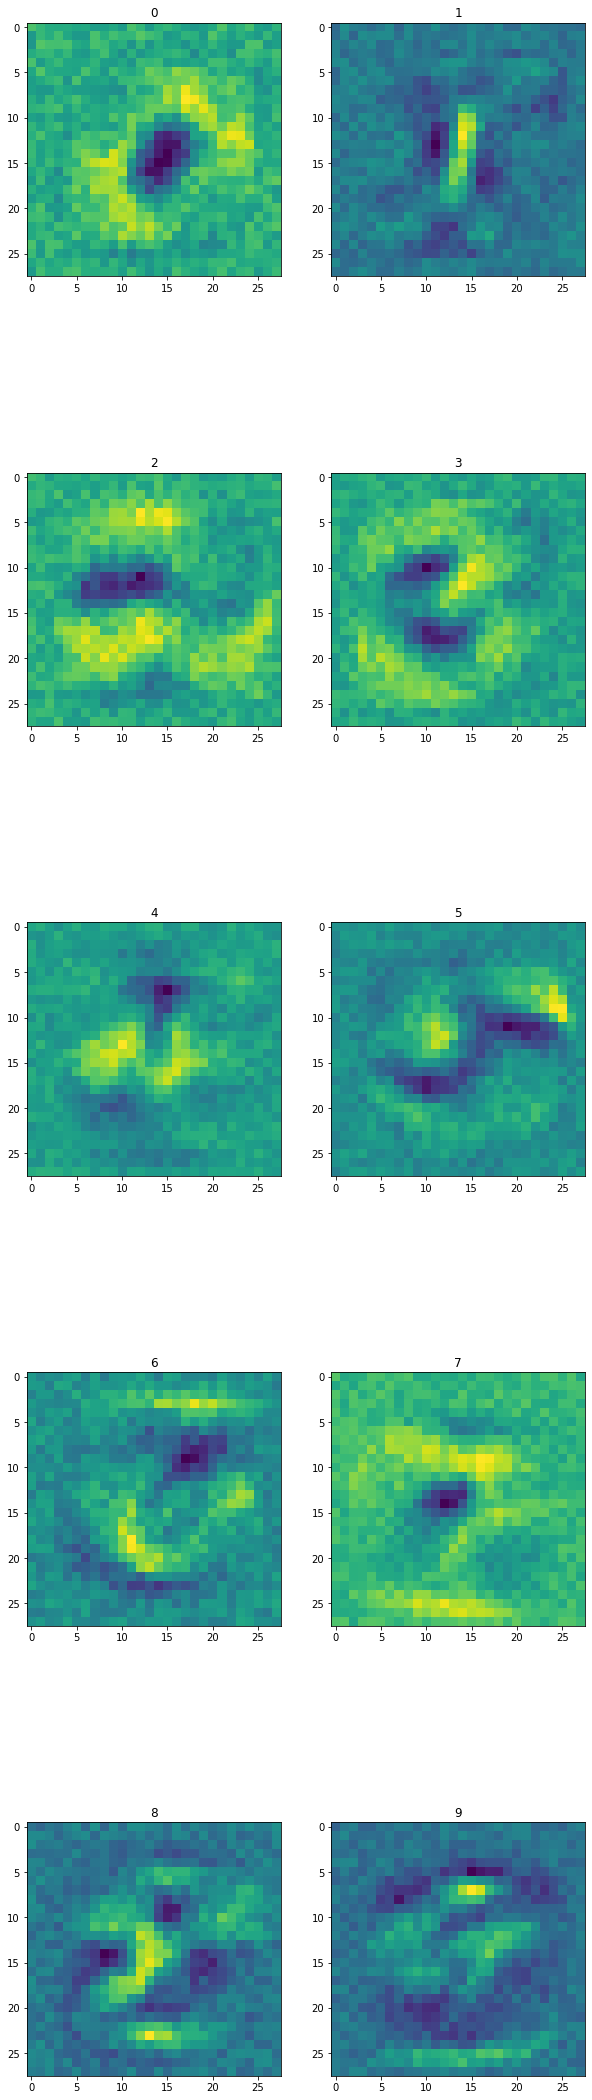

In [39]:
# Visualizing each class's weights
unfolded = list(model.parameters())[0].detach().numpy()
print(unfolded.shape)

fig, axs = plt.subplots(nrows=5, ncols=2)
fig.set_size_inches(10, 40)
label = 0

for ax in axs.ravel():
    ax.imshow(unfolded[label].reshape(28,28))
    ax.set_title(str(label))
    label += 1
plt.show()

### (c)  Use  the  Multilayer  Perceptron  (MLP)  module  in  Scikit-learn  python toolbox  to  learn  the  MLP  (with  a  single  hidden  layer)  to  perform  10 category classification over the given dataset. Use SoftMax as the activation function for the 10 output nodes. Experiment with the number of  nodes  in  the  hidden  layer.  Report  the  class-wise  F1-scores  and  the overall  accuracy.  Report  results  for  different  number  of  nodes  in  the hidden layer. Also, compare the performance with experiment in performed in (a). 

In [40]:
# Defining MLP
class Multi_layer_Perceptron1(torch.nn.Module):
    def __init__(self,hidden_size):
        super(Multi_layer_Perceptron1, self).__init__()
        self.fc = nn.Linear(784,hidden_size)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(hidden_size,10)
        self.soft = nn.Softmax(dim = 1)
        
    def forward(self, x):
        f_o = self.fc(x)
        f_o_a = self.relu(f_o)
        h_o = self.hidden(f_o_a)
        output = self.soft(h_o)
        return output

In [41]:
m_model = Multi_layer_Perceptron1(250)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(m_model.parameters(), lr = 1)

In [42]:
# Training
m_model.train()
epoch = 500
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = m_model(x_train.float())
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
    if((epoch+1)%50==0):
           print('Epoch {}: train loss: {}'.format(epoch+1, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

Epoch 50: train loss: 1.5808629989624023
Epoch 100: train loss: 1.5475237369537354
Epoch 150: train loss: 1.5339442491531372
Epoch 200: train loss: 1.5253065824508667
Epoch 250: train loss: 1.5190179347991943
Epoch 300: train loss: 1.514129877090454
Epoch 350: train loss: 1.51022207736969
Epoch 400: train loss: 1.5069479942321777
Epoch 450: train loss: 1.5041247606277466
Epoch 500: train loss: 1.5016237497329712


In [43]:
#testing
m_model.eval()
y_pred_test = m_model(x_test.float()).squeeze().detach().numpy()
print(y_pred_test.shape)

yhat =[]
for vals in y_pred_test:
    yhat.append(vals.argmax())

y_test = ytest.detach().numpy().astype(np.float32)
F1score = f1_score(y_test,yhat,average = None)
Accuracy = accuracy_score(y_test,yhat)

print("F1-Scores of Each class:" , F1score,"\nOverall Accuracy: ",Accuracy)

(10000, 10)
F1-Scores of Each class: [0.9743073  0.9833187  0.94752187 0.95177165 0.95484526 0.94968909
 0.959375   0.94803303 0.94117647 0.94472362] 
Overall Accuracy:  0.9559


### (d)  Try  improving  the  performance  of  the  MLP  by  adding  more  hidden layers.  Experiment  with  the  number  of  nodes  in  each  hidden  layer. Report  your  best  performance  (in  terms  of  class-wise  F1-scores  and overall accuracy) on the MNIST dataset.

In [44]:
# Defining MLP with more hidden layers
class Multi_layer_Perceptron2(torch.nn.Module):
    def __init__(self,hidden_size1,hidden_size2):
        super(Multi_layer_Perceptron2, self).__init__()
        self.fc = nn.Linear(784,hidden_size1)
        self.sig1 = nn.ReLU()
        self.hidden1 = nn.Linear(hidden_size1,hidden_size2)
        self.sig2 = nn.ReLU()
        self.hidden2 = nn.Linear(hidden_size2,10)
        self.soft = nn.Softmax(dim = 1)
        
    def forward(self, x):
        f_o = self.fc(x)
        f_o_a = self.sig1(f_o)
        fh_o = self.hidden1(f_o_a)
        fh_o_a = self.sig2(fh_o)
        sh_o = self.hidden2(fh_o_a)
        output = self.soft(sh_o)
        return output

In [45]:
m2_model = Multi_layer_Perceptron2(500,200)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(m2_model.parameters(), lr = 1)

In [46]:
# Train
m2_model.train()
epoch = 500
for epoch in range(epoch):
    
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = m2_model(x_train.float())
    
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
    
    if((epoch+1)%50==0):
           print('Epoch {}: train loss: {}'.format(epoch+1, loss.item()))
    
    # Backward pass
    loss.backward()
    optimizer.step()

Epoch 50: train loss: 1.6156100034713745
Epoch 100: train loss: 1.5429109334945679
Epoch 150: train loss: 1.5251367092132568
Epoch 200: train loss: 1.5148022174835205
Epoch 250: train loss: 1.5077670812606812
Epoch 300: train loss: 1.5026350021362305
Epoch 350: train loss: 1.4985713958740234
Epoch 400: train loss: 1.4952497482299805
Epoch 450: train loss: 1.4925552606582642
Epoch 500: train loss: 1.490240454673767


In [47]:
#test
m2_model.eval()
y_pred_test = m2_model(x_test.float()).squeeze().detach().numpy()
yhat = []

for vals in y_pred_test:
    yhat.append(vals.argmax())

y_test = ytest.detach().numpy().astype(np.float32)
F1score = f1_score(y_test,yhat,average=None)
Accuracy = accuracy_score(y_test,yhat)
print("F1-Scores of Each class:" , F1score,"\nOverall Accuracy: ",Accuracy)

F1-Scores of Each class: [0.97773279 0.98375055 0.95500726 0.96325331 0.96379398 0.96062992
 0.96555324 0.95618306 0.95611771 0.94831912] 
Overall Accuracy:  0.9633
